<a href="https://colab.research.google.com/github/JeanJulesBigeard/Getting-started-with-OpenCV/blob/master/Text_Detection/6_Tesseract_with_Text_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">OCR pipeline with Tesseract and CRAFT Text Detection</font>
In the previous section, we saw how Tesseract failed to recognize words and also discussed a few methods to improve Text Recognition accuracy. However, there were cases where the discussed methods did not work. We also saw that if we supplied Tesseract with detected text, it was able to identify those text images. 

In this notebook, we will discuss how to use the CRAFT text detection model along with Tesseract. In other words, we want to divide the OCR task into 
1. Text Detection - using CRAFT 
1. Text Recognition - using Tesseract.

We have already seen the above two in action seprately in the previous notebooks. We will create a simple pipeline to combine the two and make the final OCR output more robust. 

In this notebook, we will first build a modified pipeline and then compare the results with the what we were getting with original Tesseract.

# <font color="blue">1. Install Tesseract & Keras-OCR package</font>

In [0]:
!apt install libtesseract-dev tesseract-ocr > /dev/null
!pip install pytesseract > /dev/null
!pip install keras-ocr > /dev/null

# <font color="blue">2. Import Libraries</font>

In [0]:
import keras_ocr
import pytesseract
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# <font color="blue">3. Download Sample Image</font>

In [0]:
!wget https://www.dropbox.com/s/vxme4py1pq0omeq/dlbook.jpg?dl=1 -O dlbook.jpg --quiet

# <font color="blue">4. Detect Text Boxes </font>

## <font color="blue">4.1. Create a Detector Object</font>
You can create a detector object using the following function. Check out the [documentation](https://keras-ocr.readthedocs.io/en/latest/api.html#keras_ocr.detection.Detector) if you need more details.

In [0]:
detector = keras_ocr.detection.Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [0]:
image = keras_ocr.tools.read("dlbook.jpg")
detections = detector.detect([image])[0]

# <font color="blue">5. Display Detected Text Boxes</font>

In [0]:
def display_boxes(image, boxes):
  img = keras_ocr.tools.drawBoxes(image.copy(),boxes)
  plt.figure(figsize=[10,10])
  plt.imshow(img)
  plt.show()

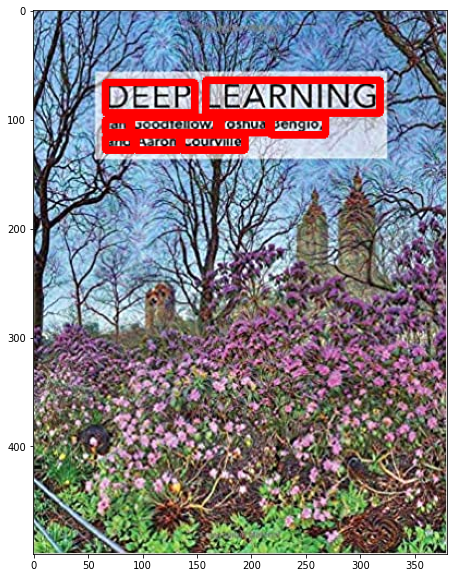

In [0]:
display_boxes(image,detections)

# <font color="blue">6. Recognize Detected Text using Tesseract</font>
We are using the detected text boxes from above to pass it to the Tesseract engine with psm = 6 ( since we expect the boxes to contain a single block of text ).

If the text is recognized, we add the text and box information in a list which is then returned.

In [0]:
def tess_recognize_from_boxes(image, detections, config):
  predictions = []
  # for each box
  for i, box in enumerate(detections):
    # get the cropped and algned image
    cropped_warped = keras_ocr.tools.warpBox(image, box)

    # Perform tesseract OCR on the cropped Text
    text = pytesseract.image_to_string(cropped_warped, config=config)
    
    # Store the text and the corresponding box 
    if text:
      predictions.append((text, box))
  return predictions  

# <font color="blue">7. Modified Pipeline for Detection and Recognition</font>
This function combines the detection (using Keras-ocr) and recognition (using Tesseract). This assumes a psm of 6 unless otherwise specified.

In [0]:
def modified_tesseract(image, config=('--psm 6')):
  # Detect the Text boxes from the image using Keras-ocr
  detections = detector.detect([image])[0]
  
  # Run tesseract on boxes defined above
  predictions = tess_recognize_from_boxes(image, detections, config)

  return predictions

# <font color="blue">8. Display Output </font>
We will use the nice function drawAnnotations available in keras-ocr to display the recognized text as shown below.

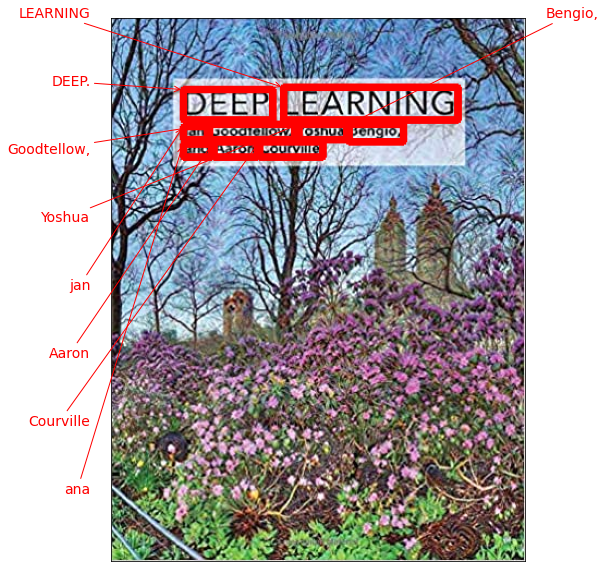

In [0]:
predictions = modified_tesseract(image)
fig,ax = plt.subplots(figsize = [10,10])
keras_ocr.tools.drawAnnotations(image, predictions, ax=ax)

# <font color="blue">9. Comparison with Original Tesseract</font>

## <font color="blue">9.1. Test Image 1: Image of a Book</font>


In [0]:
!wget https://www.dropbox.com/s/uwrdek4jjac4ysz/book2.jpg?dl=1 -O book2.jpg --quiet

### <font color="green">Downloaded Image</font>

<img src="https://www.dropbox.com/s/uwrdek4jjac4ysz/book2.jpg?dl=1" width=500>

### <font color="green">Tesseract Output</font>

In [0]:
book2_text = pytesseract.image_to_string('book2.jpg')
print(book2_text)

The Impact of the Highly Improbable


### <font color="green">Modified Tesseract Output </font>

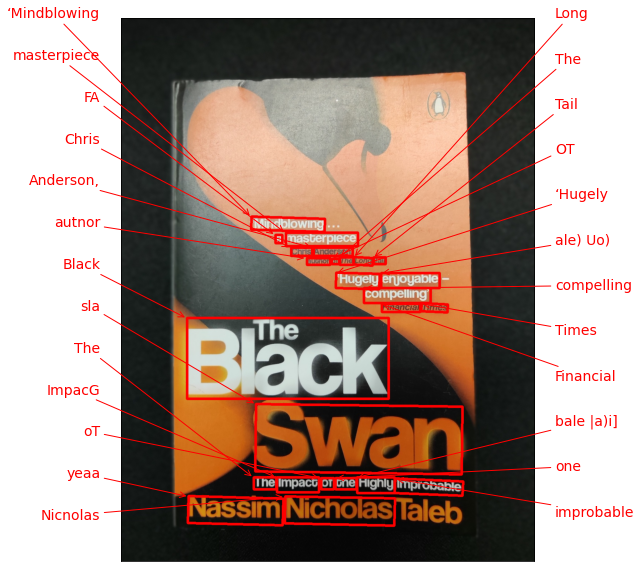

In [0]:
image = keras_ocr.tools.read("book2.jpg")
predictions = modified_tesseract(image)
fig,ax = plt.subplots(figsize = [10,10])
keras_ocr.tools.drawAnnotations(image, predictions, ax=ax)

### <font color="green">Observation </font>
It is able to detect so many of the text which was not recognized earlier. However, it also misses out on those which were recognized earlier like `Impact`, `Highly`. However, we can say that the overall performance has increased considerably for this example.

## <font color="blue">9.2. Street Signs</font>
As we saw in the previous notebook, the default setting could not detect a single word from the street sign images. Let us see if the output improves using the new pipeline!

# <font color="blue">Test Image 2</font>

In [0]:
!wget https://www.dropbox.com/s/uwlnxiihqgni57o/streetsign1.jpg?dl=0 -O streetsign1.jpg --quiet

### <font color="green">Downloaded Image</font>
<img src="https://www.dropbox.com/s/uwlnxiihqgni57o/streetsign1.jpg?dl=1" width=500>

### <font color="green">Modified Tesseract Output</font>

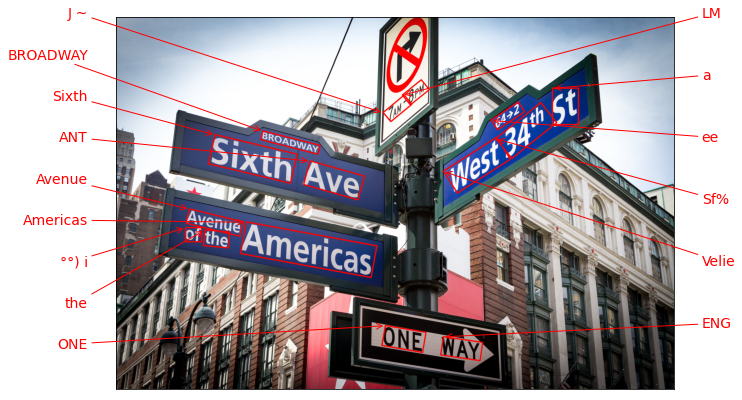

In [0]:
image = keras_ocr.tools.read("streetsign1.jpg")
predictions = modified_tesseract(image)
fig,ax = plt.subplots(figsize = [10,10])
keras_ocr.tools.drawAnnotations(image, predictions, ax=ax)

## <font color="blue">Test Image 3</font>

In [0]:
!wget https://www.dropbox.com/s/dbkag5gsicxqoqg/streetsign2.jpg?dl=0 -O streetsign2.jpg --quiet

### <font color="green">Downloaded Image</font>
<img src="https://www.dropbox.com/s/dbkag5gsicxqoqg/streetsign2.jpg?dl=1" width=500>

### <font color="green">Modified Tesseract Output</font>

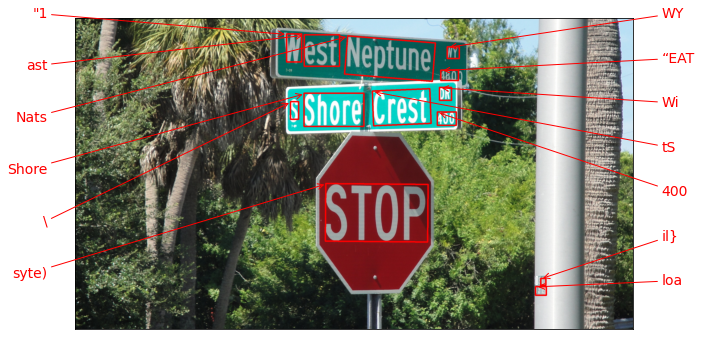

In [0]:
image = keras_ocr.tools.read("streetsign2.jpg")
predictions = modified_tesseract(image)
fig,ax = plt.subplots(figsize = [10,10])
keras_ocr.tools.drawAnnotations(image, predictions, ax=ax)

## <font color="blue">Test Image 4</font>

In [0]:
!wget https://www.dropbox.com/s/cgni28zl1k9sesk/streetsign3.jpg?dl=0 -O streetsign3.jpg --quiet

### <font color="green">Downloaded Image</font>
<img src="https://www.dropbox.com/s/cgni28zl1k9sesk/streetsign3.jpg?dl=1" width=500>

### <font color="green">Modified Tesseract Output</font>

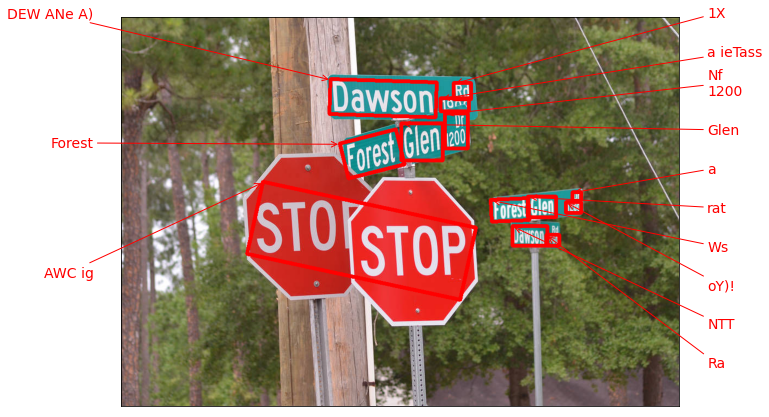

In [0]:
image = keras_ocr.tools.read("streetsign3.jpg")
predictions = modified_tesseract(image)
fig,ax = plt.subplots(figsize = [10,10])
keras_ocr.tools.drawAnnotations(image, predictions, ax=ax)

# <font color="blue">10. Conclusion</font>
We have seen the improvements achieved using the modified pipeline.